In [35]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('data.csv')

In [23]:
single_value_columns = [
    'Sensing_PANEL_No Additional Sensing', 'Interaction_PANEL_Hands-Free', 'Interaction_PANEL_Eyes-Free', 
    'Interaction_PANEL_Adaptation of the Interaction Detection Algorithm to the Individual User',
    'Interaction_PANEL_Discreetness of Interaction Techniques', 
    'Interaction_PANEL_Social Acceptability of Interaction Techniques',
    'Interaction_PANEL_Accuracy of Interaction Recognition',
    'Interaction_PANEL_Robustness of Interaction Detection',
    'Study_PANEL_Elicitation Study',
    'Study_PANEL_Usability Evaluations',
    'Study_PANEL_Cognitive Ease Evaluations',
    'Study_PANEL_Discreetness of Interactions Evaluations',
    'Study_PANEL_Social Acceptability of Interactions Evaluations',
    'Study_PANEL_Accuracy of Interactions Evaluations',
    'Study_PANEL_Alternative Interaction Validity Evaluations',
    'Device_PANEL_Real-Time Processing', 'Device_PANEL_On-Device Processing'
]

multi_value_and_string_columns = [
    'Location', 'Input Body Part', 'Gesture', 'Sensing_PANEL_Sensors', 'Interaction_PANEL_Resolution', 
    'Study_PANEL_Evaluation of Different Conditions',
    'Study_PANEL_Evaluation of Different Settings',
    'Device_PANEL_Earphone Type', 'Device_PANEL_Development Stage',
    'Applications_PANEL_Intended Applications', 'Keywords'
]

numerical_columns = [
    'Year'
]

numerical_columns_log_transformed = [
    'Interaction_PANEL_Number of Selected Gestures'
]

single_value_columns_special_treatment = ['Interaction_PANEL_Possible on One Ear']



In [33]:
# Function to transform values based on partial matches
def transform_value(value):
    if pd.isna(value):
        return np.nan
    
    # Convert to string to ensure we can perform string operations
    value_str = str(value).lower()
    
    # Check for patterns
    if re.search(r'\byes\b', value_str):
        return 1.0
    elif re.search(r'\bno\b', value_str):
        return 0.0
    elif re.search(r'\blow\b', value_str):
        return 0.0
    elif re.search(r'\bmedium\b', value_str):
        return 0.5
    elif re.search(r'\bhigh\b', value_str):
        return 1.0
    elif re.search(r'\bvisual attention\b', value_str):
        return 0.5
    elif re.search(r'\bpartly\b', value_str):
        return 0.5
    elif re.search(r'\bn\/a\b', value_str) or value_str == 'n/a':
        return np.nan
    else:
        return np.nan
    
df_transformed = df.copy()
df_transformed = df_transformed.drop(columns=['First Author', 'Study Link', 'Abstract'])

# Apply the transformation to each column in single_value_columns
for col in single_value_columns:
    if col in df_transformed.columns:
        df_transformed[col] = df_transformed[col].apply(transform_value)
        
# Apply min-max scaling using pandas
for col in numerical_columns:
    if col in df_transformed.columns:
        df_transformed[col] = (df_transformed[col] - df_transformed[col].min()) / (df_transformed[col].max() - df_transformed[col].min())
        
# Apply min-max scaling using pandas
for col in numerical_columns_log_transformed:
    if col in df_transformed.columns:
        # Apply natural log transformation
        df_transformed[col] = np.log(df_transformed[col])
        df_transformed[col] = (df_transformed[col] - df_transformed[col].min()) / (df_transformed[col].max() - df_transformed[col].min())
        
# Transform the special treatment column
for col in single_value_columns_special_treatment:
    if col in df_transformed.columns:
        # Define a mapping dictionary for exact matching
        special_mapping = {
            'Yes': 1.0,
            'Yes (Performance Loss)': 0.5,
            'No': 0.0,
            'N/A': np.nan
        }
        
        # Apply the mapping directly
        df_transformed[col] = df_transformed[col].map(special_mapping)

In [36]:
# Create a function to calculate similarity between two studies
def calculate_similarity(row1, row2, numeric_columns, string_columns):
    similarity = 0
    total_features = 0
    
    # Handle numerical columns with absolute difference
    for col in numeric_columns:
        if col in row1 and col in row2:
            # Skip if the column is 'ID'
            if col == 'ID':
                continue
                
            # Get the values
            val1 = row1[col]
            val2 = row2[col]
            
            # Calculate similarity based on absolute difference
            if pd.isna(val1) or pd.isna(val2):
                # If either value is NaN, use maximum difference
                similarity += 0  # 1-1=0 (using 1 as max difference)
            else:
                # Otherwise calculate absolute difference and invert (1-diff)
                # Since values are normalized to [0,1], the difference is also [0,1]
                similarity += 1 - abs(val1 - val2)
            
            total_features += 1
    
    # Handle string/multi-value columns with adjusted Jaccard similarity
    for col in string_columns:
        if col in row1 and col in row2:
            # Skip if the column is 'ID'
            if col == 'ID':
                continue
                
            # Get the values and convert to sets
            # Handle NaN, empty strings, etc.
            val1 = row1[col]
            val2 = row2[col]
            
            if pd.isna(val1) or pd.isna(val2) or val1 == '' or val2 == '':
                similarity += 0  # No similarity if either is empty/NaN
            else:
                # Split by common separators like comma, semicolon, etc.
                # and convert to sets
                set1 = set(str(val1).split(','))
                set2 = set(str(val2).split(','))
                
                # Calculate intersection length
                intersection_len = len(set1.intersection(set2))
                
                # Calculate adjusted Jaccard similarity
                denominator = (len(set1) * len(set2))**0.5
                if denominator > 0:
                    similarity += intersection_len / denominator
                else:
                    similarity += 0
                    
            total_features += 1
    
    # Return average similarity across all features
    if total_features > 0:
        return similarity / total_features
    else:
        return 0

# Get all numeric columns (excluding those in multi_value_and_string_columns)
numeric_cols = [col for col in df_transformed.columns 
                if col not in multi_value_and_string_columns and col != 'ID']

# Create empty similarity matrix
study_ids = df_transformed['ID'].tolist()
n_studies = len(study_ids)
similarity_matrix = pd.DataFrame(np.zeros((n_studies, n_studies)), 
                              index=study_ids, 
                              columns=study_ids)

# Calculate pairwise similarities
for i, id1 in enumerate(study_ids):
    row1 = df_transformed.loc[df_transformed['ID'] == id1].iloc[0]
    
    # For diagonal elements (self-similarity)
    similarity_matrix.loc[id1, id1] = 1.0
    
    # For upper triangular matrix
    for j in range(i+1, n_studies):
        id2 = study_ids[j]
        row2 = df_transformed.loc[df_transformed['ID'] == id2].iloc[0]
        
        # Calculate similarity
        sim = calculate_similarity(row1, row2, numeric_cols, multi_value_and_string_columns)
        
        # Fill both upper and lower triangular parts
        similarity_matrix.loc[id1, id2] = sim
        similarity_matrix.loc[id2, id1] = sim  # Symmetric matrix

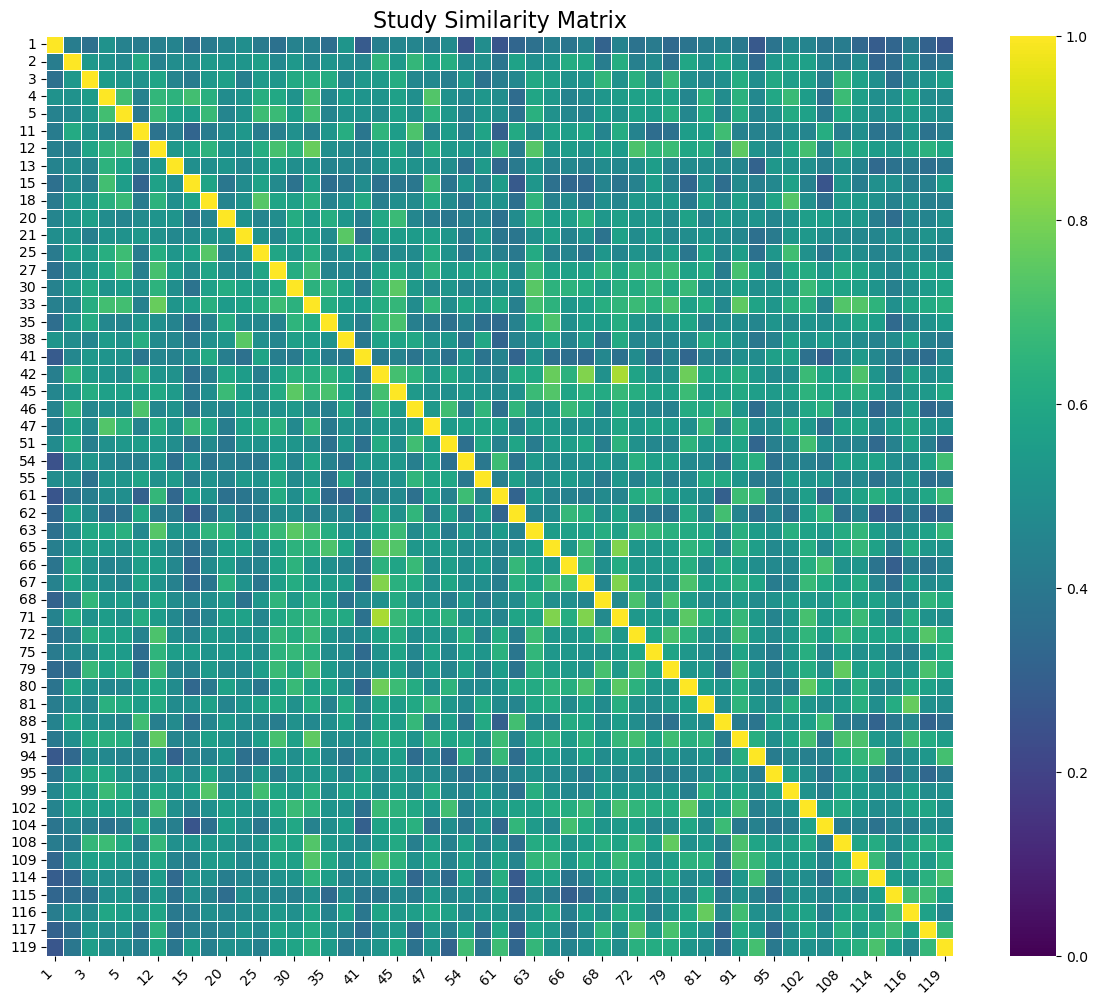

In [37]:
# Set up the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap with seaborn
ax = sns.heatmap(similarity_matrix, 
                 cmap='viridis',  # You can use other colormaps like 'YlGnBu', 'coolwarm', 'RdBu_r'
                 annot=False,     # Set to True if you want to see values in cells (but may be crowded)
                 linewidths=0.5,
                 vmin=0,          # Minimum similarity value
                 vmax=1)          # Maximum similarity value

# Add title and labels
plt.title('Study Similarity Matrix', fontsize=16)
plt.tight_layout()

# Rotate tick labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

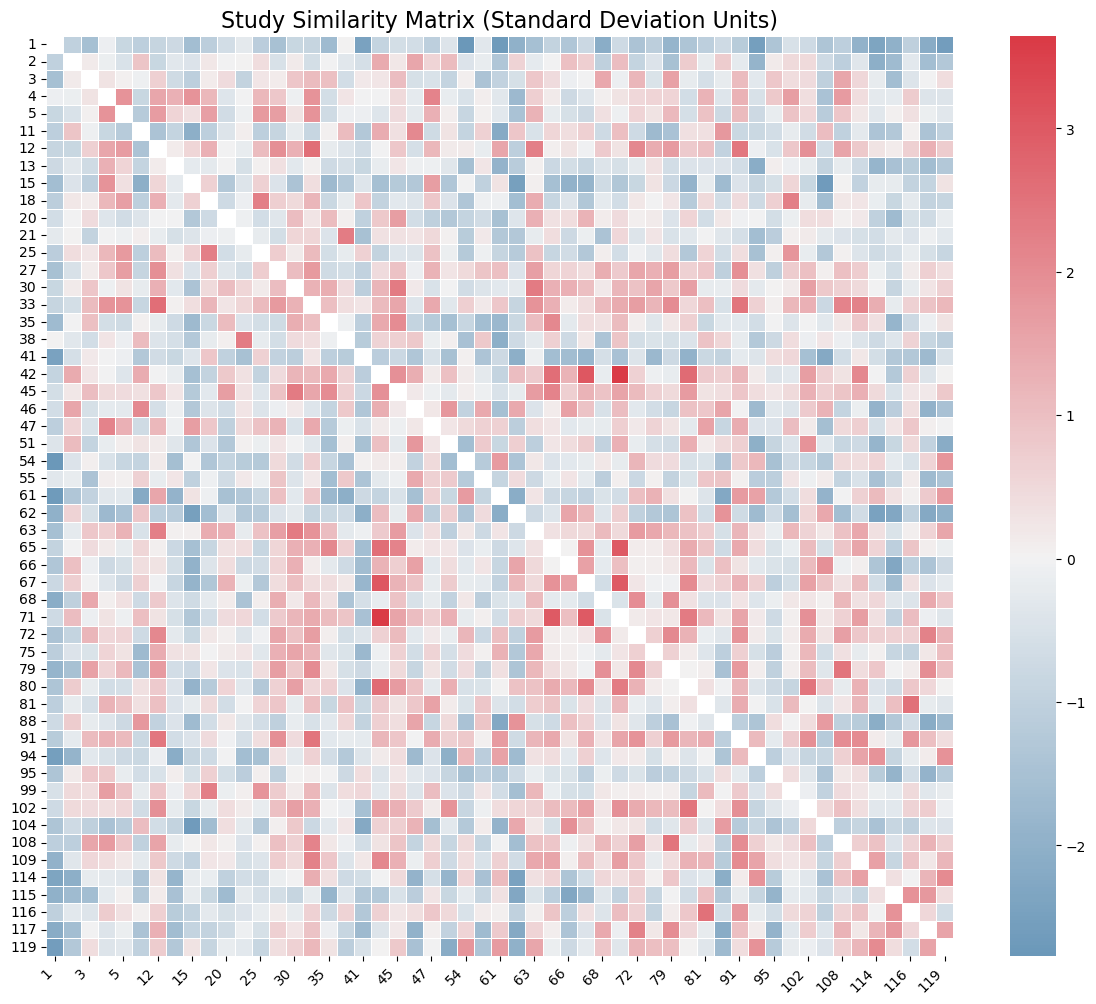

In [39]:
# Calculate the mean and standard deviation of similarity values, excluding the diagonal
similarity_values = []
n = similarity_matrix.shape[0]
for i in range(n):
    for j in range(n):
        if i != j:  # Skip diagonal elements
            similarity_values.append(similarity_matrix.iloc[i, j])
            
mean_similarity = np.mean(similarity_values)
std_similarity = np.std(similarity_values)

# Create a new matrix with values in standard deviation units
similarity_matrix_std = similarity_matrix.copy()
for i in range(n):
    for j in range(n):
        if i != j:  # Skip diagonal elements
            similarity_matrix_std.iloc[i, j] = (similarity_matrix.iloc[i, j] - mean_similarity) / std_similarity
        else:
            # Set diagonal elements to NaN to exclude them from the visualization
            similarity_matrix_std.iloc[i, j] = np.nan

# Set up a new figure for the standardized visualization
plt.figure(figsize=(12, 10))

# Create a diverging colormap centered at 0 (mean similarity)
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Create a heatmap with seaborn
ax = sns.heatmap(similarity_matrix_std, 
                 cmap=cmap,
                 annot=False,
                 linewidths=0.5,
                 center=0,  # Center colormap at 0 (mean)
                 mask=np.isnan(similarity_matrix_std))  # Mask NaN values

# Add title and labels
plt.title('Study Similarity Matrix (Standard Deviation Units)', fontsize=16)
plt.tight_layout()

# Rotate tick labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [42]:
# Save the std similarity matrix to a CSV file
similarity_matrix_std.to_csv('database_similarity_datasets/normalized_database_similarity.csv')